<a href="https://colab.research.google.com/github/martinrosch/twai_lnw/blob/main/Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
pip install -q folktables

In [41]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [42]:
# Specify here which state and year the model should be trained (and tested) on
training_state = 'PA'
training_year = 2014
training_horizon = '1-Year'
# For task 6: Specify here in which state and when the model should be deployed
deployment_state = 'PA'
deployment_year = 2018
deployment_horizon = '1-Year'

# Setup

## Get training and testing data

Wir wenden für unseren Fall zusätzlich die folgenden zwei Filter an:
* AGEP (Alter) muss größer als 24 und kleiner als 66 sein.
* RAC1P (Kodierte detaillierte Rassenzuordnung) darf nur 1 (Weiß) oder 2 (Schwarz oder Afroamerikaner) sein.

Alle anderen Datensätze werden aus dem Datensatz eliminiert.

In [43]:
def preprocess_data(features, label, group):
  # Age
  ix_right_age_group = (features[:,0]>=25) & (features[:,0]<=65)
  features = features[ix_right_age_group]
  label = label[ix_right_age_group]
  group = group[ix_right_age_group]
  # Race
  ix_bw = (group==1) | (group==2)
  features = features[ix_bw]
  label = label[ix_bw]
  group = group[ix_bw]

  return (features, label, group)

In [44]:
from folktables import ACSDataSource, ACSEmployment, generate_categories
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data_source = ACSDataSource(survey_year=training_year, horizon=training_horizon, survey='person')
acs_data = data_source.get_data(states=[training_state], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
features, label, group = preprocess_data(features, label, group)

### How successful are the job coaches?
Base rate: Probability of finding employment within the first year of working with the job coaches

In [45]:
np.mean(label)

np.float64(0.710184182015168)

## Analyze Data

Get feature and target names

In [46]:
print(f"Feature names: {ACSEmployment.features}")
print(f"Label name: {ACSEmployment.target}")

Feature names: ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
Label name: ESR


Convert code into a name and save in dict

In [47]:
feature_and_target_names = {
    'AGEP': 'Age',
    'SCHL': 'Education',
    'MAR': 'Marital Status',
    'RELP': 'Relationship',
    'DIS': 'Disability Status',
    'ESP': 'Parental Employment Status',
    'CIT': 'Citizenship Status',
    'MIG': 'Mobility Status',
    'MIL': 'Military Service',
    'ANC': 'Ancestry',
    'NATIVITY': 'Place of Birth',
    'DEAR': 'Hearing Difficulty',
    'DEYE': 'Vision Difficulty',
    'DREM': 'Cognitive Difficulty',
    'SEX': 'Sex',
    'RAC1P': 'Race',
    'ESR': 'Employment Status'
}

print(feature_and_target_names)

{'AGEP': 'Age', 'SCHL': 'Education', 'MAR': 'Marital Status', 'RELP': 'Relationship', 'DIS': 'Disability Status', 'ESP': 'Parental Employment Status', 'CIT': 'Citizenship Status', 'MIG': 'Mobility Status', 'MIL': 'Military Service', 'ANC': 'Ancestry', 'NATIVITY': 'Place of Birth', 'DEAR': 'Hearing Difficulty', 'DEYE': 'Vision Difficulty', 'DREM': 'Cognitive Difficulty', 'SEX': 'Sex', 'RAC1P': 'Race', 'ESR': 'Employment Status'}


Convert feature and target into a dataframe and apply colum names

In [48]:
import pandas as pd

df_feature = pd.DataFrame(features, columns=ACSEmployment.features)
df_target = pd.DataFrame(label, columns=[ACSEmployment.target])

In [49]:
df_feature

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
0,56.0,16.0,4.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0
1,28.0,19.0,5.0,2.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0
2,40.0,19.0,4.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
3,58.0,20.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
4,58.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64605,38.0,16.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0
64606,42.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0
64607,39.0,17.0,5.0,16.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,1.0,1.0
64608,45.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0


In [50]:
df_target

,ESR
0,True
1,True
2,True
3,False
4,False
...,...
64605,False
64606,True
64607,False
64608,True


### Histogram for features

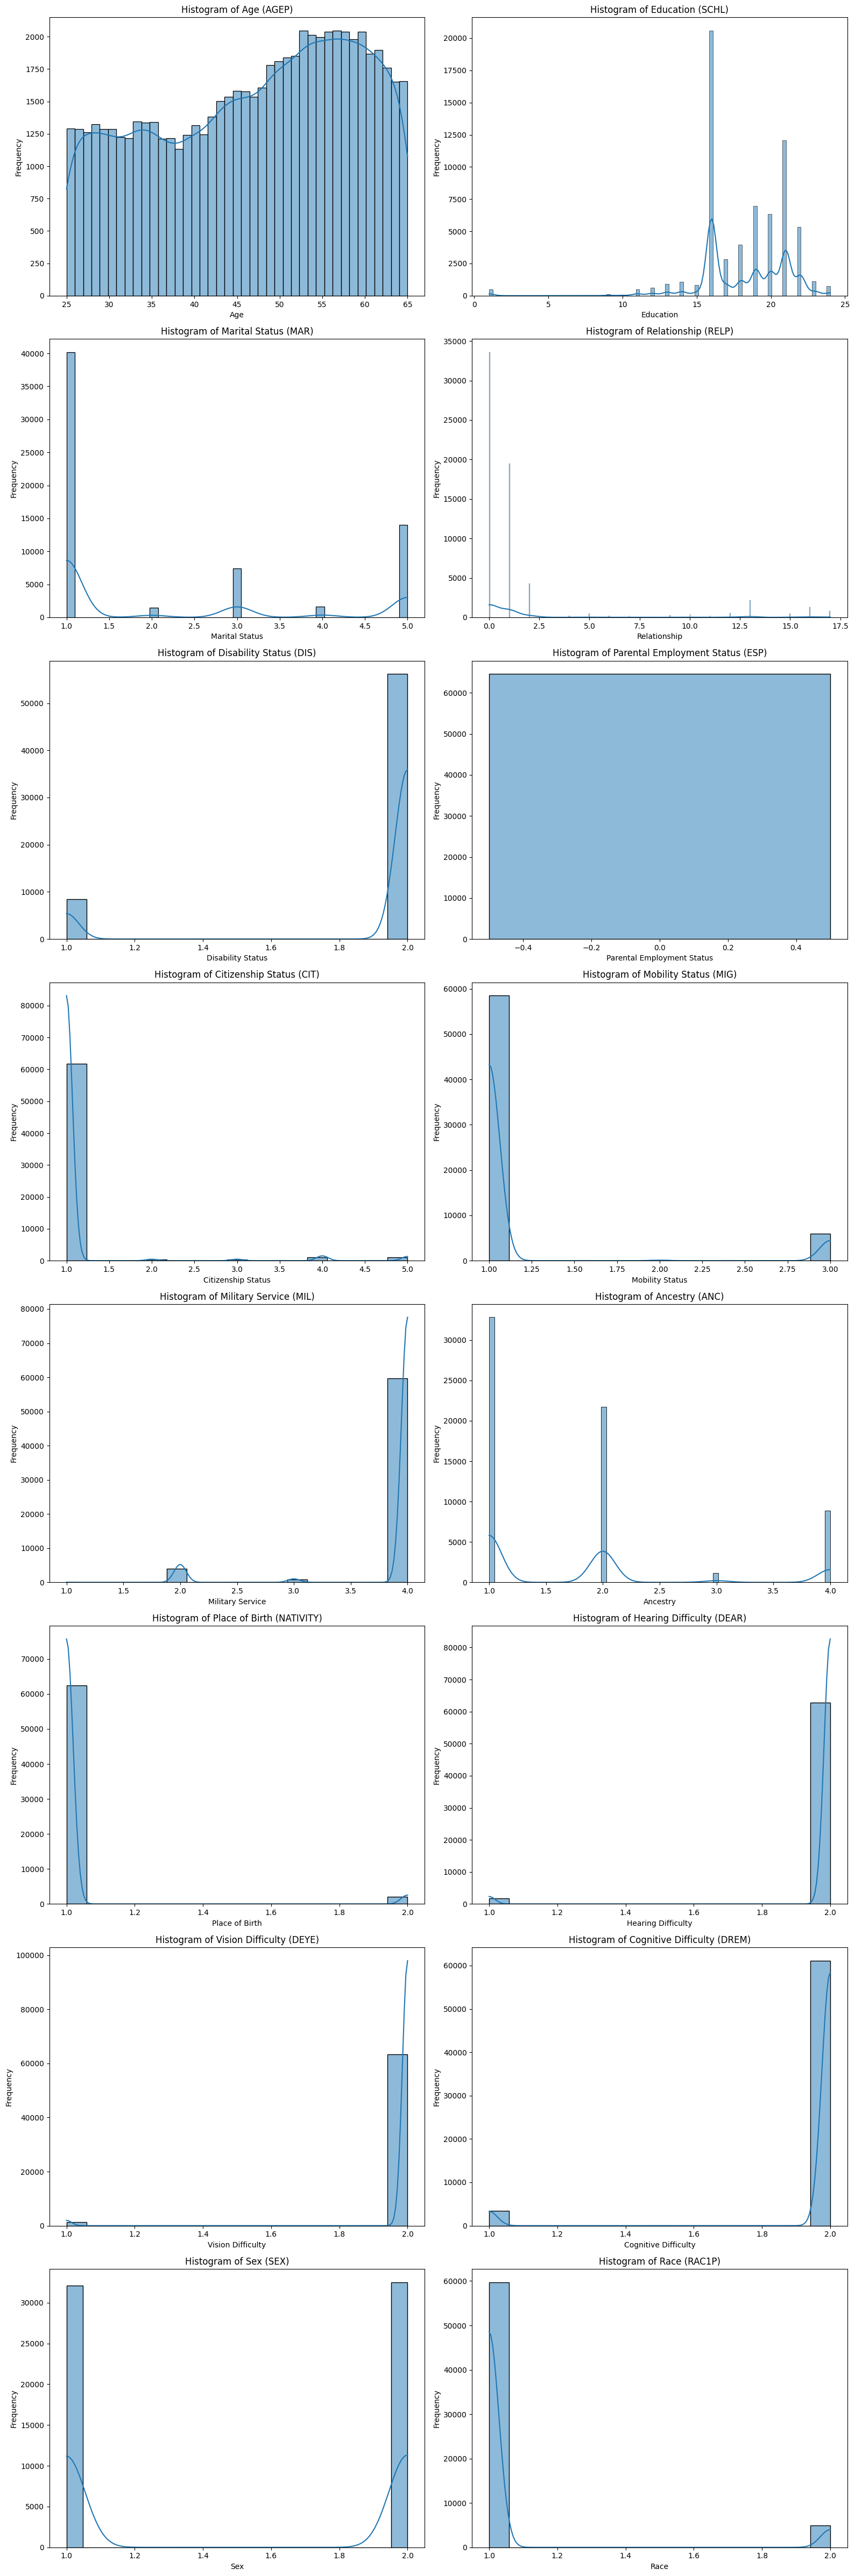

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_features = len(df_feature.columns)
num_cols = 2
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, column in enumerate(df_feature.columns):
    sns.histplot(df_feature[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature_and_target_names.get(column, column)} ({column})')
    axes[i].set_xlabel(feature_and_target_names.get(column, column))
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Boxplot for features

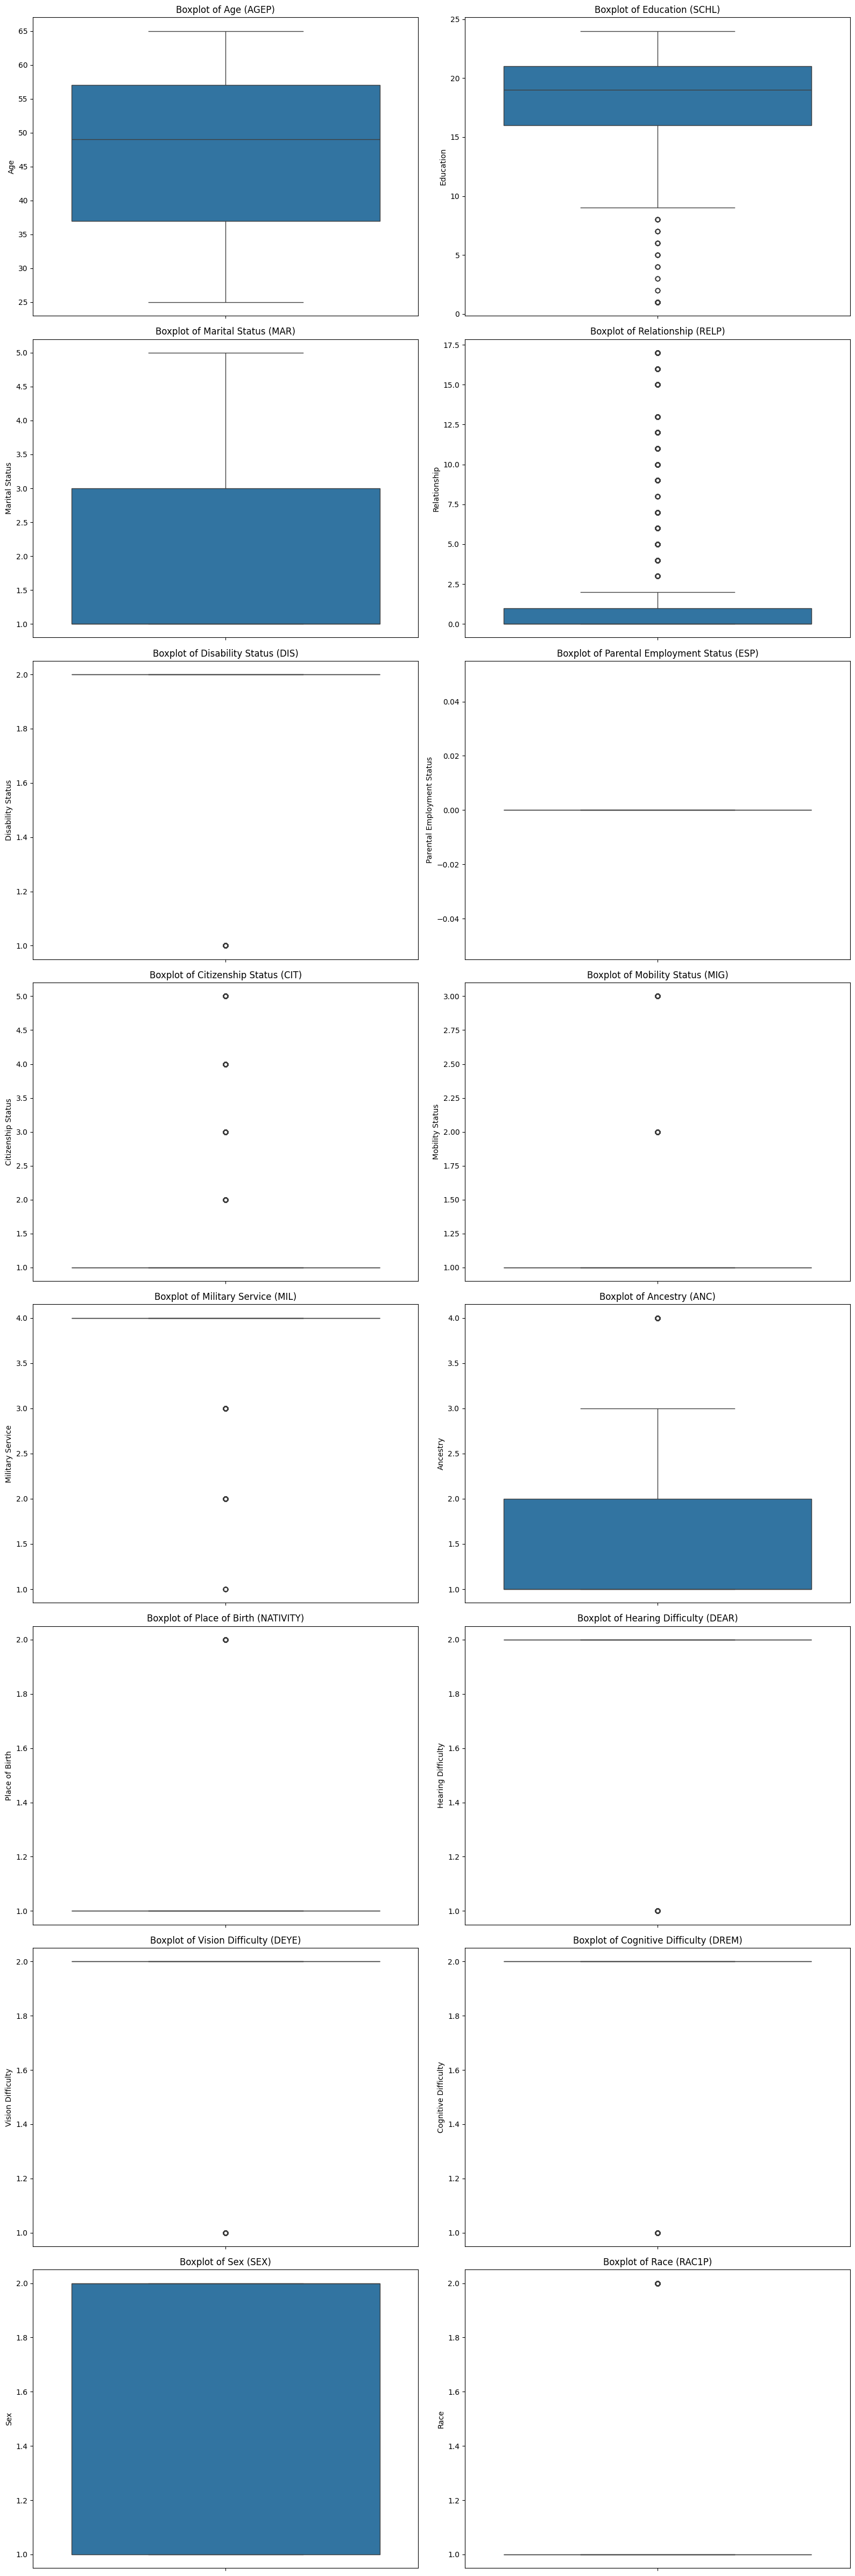

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_features = len(df_feature.columns)
num_cols = 2
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, column in enumerate(df_feature.columns):
    sns.boxplot(y=df_feature[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature_and_target_names.get(column, column)} ({column})')
    axes[i].set_ylabel(feature_and_target_names.get(column, column))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Distribution for target

Der Datensatz enthält für jede Person zum einen die binäre Zielvariable ESR, die wir vorhersagen wollen. In der bisherigen Notation haben wir diese Variable mit Y bezeichnet.

Konkret: Y=1, wenn ESR==1, und Y=0 sonst.

ESR bezeichnet in Wirklichkeit die Beschäftigungssituation einer Person. Für diese Studie gehen wir aber davon aus, ESR bedeutet: «diese Person findet eine Arbeit, wenn sie ins Jobcoach-Programm aufgenommen wurde». Damit können wir einen semi-realen Datensatz für unsere Anwendung erzeugen.
* Y=1 bedeutet also, dass der Arbeitssuchende nach 1 Jahr Zusammenarbeit mit den Jobcoaches eine neue Beschäftigung gefunden hat.
* Y=0 bedeutet, dass der Arbeitssuchende trotz der Hilfe der Jobcoaches keine neue Beschäftigung gefunden hat.

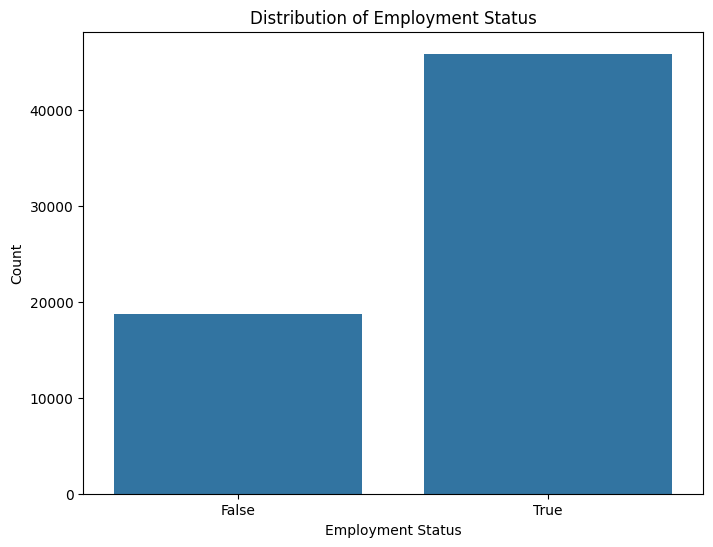

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=df_target[ACSEmployment.target])
plt.title(f'Distribution of {feature_and_target_names.get(ACSEmployment.target, ACSEmployment.target)}')
plt.xlabel(feature_and_target_names.get(ACSEmployment.target, ACSEmployment.target))
plt.ylabel('Count')
plt.show()

## Train the model

In [54]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Make predictions

In [55]:
yhat = model.predict(X_test)
scores = model.predict_proba(X_test)[:,1]

# Task 1

**Wie gut ist das trainierte Modell? (6 Punkte)**

Wir möchten nun die Leistung des Modells anhand der Testdaten bewerten. Testdaten sind die oben selektierten 20% der Daten aus dem Jahr 2014, die nicht zum Training des Prediction-Modells verwendet wurden.

## Task 1.1
(2 Punkte) Als vorläufigen Test berechnen Sie die Accuracy des Klassifikationsmodells (unter Verwendung des Standard-Schwellenwerts von 0.5 für den Score - Funktion model.predict()).

In [56]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, yhat)
print(f"Model Accuracy on Test Data: {accuracy:.4f}")

Model Accuracy on Test Data: 0.7650


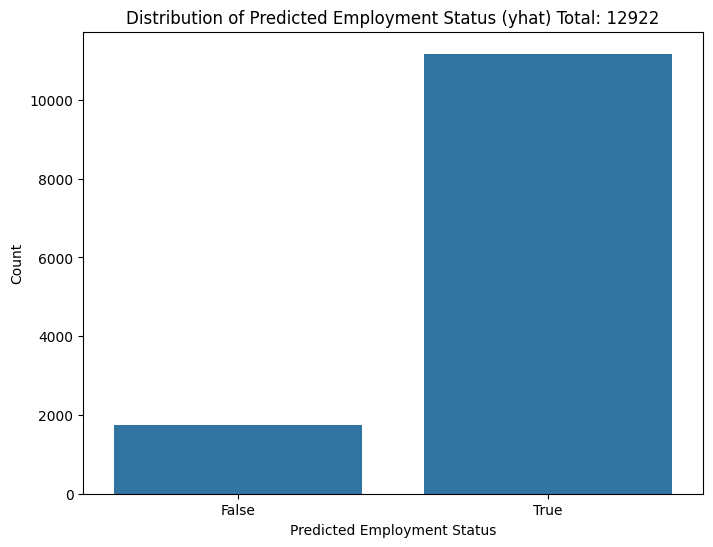

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=yhat)
plt.title('Distribution of Predicted Employment Status (yhat) Total: ' + str(yhat.shape[0]))
plt.xlabel('Predicted Employment Status')
plt.ylabel('Count')
plt.show()

## Task 1.2
(2 Punkte) Überprüfen Sie weiterhin die Kalibrierung des Modells. Hinweis: Teilen Sie die Scores in 10 Bins {[0,0.1), [0.1,0.2), …, [0.8,0.9) , [0.9,1]}.
Für jedes Bin 𝑖𝑖=1,…,10 berechnen Sie:
* 𝑥𝑥𝑖𝑖: Den Durchschnittswert der Scores aller Personen in diesem Bin.
* 𝑦𝑦𝑖𝑖: Die durchschnittliche faktische Wiedereinstellungsrate (gemessen mit Y) aller Personen in diesem Bin.

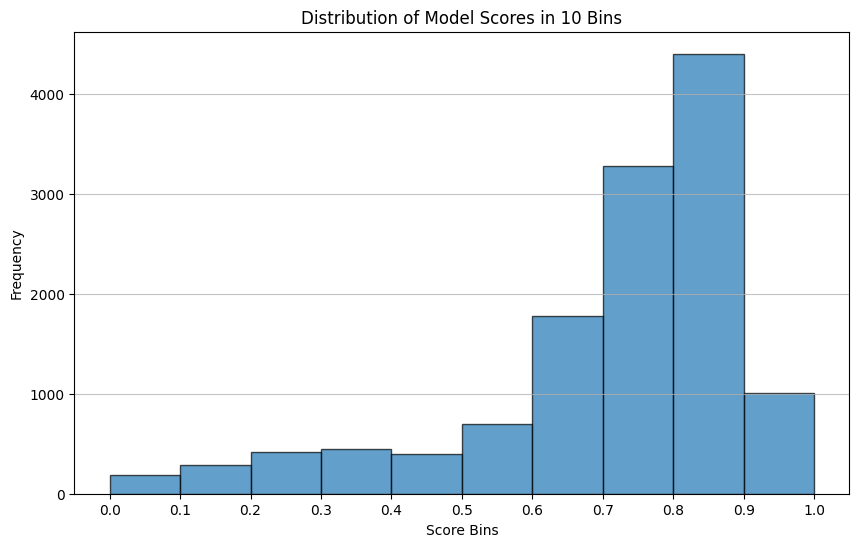

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create bins from 0 to 1 with 10 intervals
bins = np.linspace(0, 1, 11) # 11 edges for 10 bins

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=bins, edgecolor='black', alpha=0.7)
plt.title('Distribution of Model Scores in 10 Bins')
plt.xlabel('Score Bins')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [59]:
import numpy as np
from scipy.stats import norm # Import norm for z-score calculation

x_ii = [] # Average predicted scores per bin
y_ii = [] # Average actual outcomes per bin
n_in_bin = [] # Number of samples in each bin
k_in_bin = [] # Number of 'successes' (True labels) in each bin

for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]

    # Select scores and actual outcomes within the current bin
    bin_mask = (scores >= lower_bound) & (scores < upper_bound)

    # If the last bin, include the upper bound
    if i == len(bins) - 2:
        bin_mask = (scores >= lower_bound) & (scores <= upper_bound)

    scores_in_bin = scores[bin_mask]
    y_test_in_bin = y_test[bin_mask]

    if len(scores_in_bin) > 0:
        x_ii.append(np.mean(scores_in_bin))
        y_ii.append(np.mean(y_test_in_bin))
        n_in_bin.append(len(y_test_in_bin))
        k_in_bin.append(np.sum(y_test_in_bin)) # Assuming y_test_in_bin contains booleans or 0/1
    else:
        x_ii.append(np.nan)
        y_ii.append(np.nan)
        n_in_bin.append(0)
        k_in_bin.append(0)

# Calculate confidence intervals (Wilson score interval) for y_ii
ci_lower = []
ci_upper = []
z = norm.ppf(0.975) # For 95% confidence interval (alpha=0.05, so 1 - alpha/2 = 0.975)

for k, n in zip(k_in_bin, n_in_bin):
    if n > 0:
        p_hat = k / n
        denominator = 1 + z**2 / n
        center = p_hat + z**2 / (2 * n)
        margin = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
        lower = (center - margin) / denominator
        upper = (center + margin) / denominator
        ci_lower.append(lower)
        ci_upper.append(upper)
    else:
        ci_lower.append(np.nan) # Cannot calculate CI if no samples
        ci_upper.append(np.nan)

# Convert to numpy arrays for easier plotting and handling NaNs
x_ii = np.array(x_ii)
y_ii = np.array(y_ii)
ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# Print results for each bin including confidence intervals
for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]
    if not np.isnan(x_ii[i]):
        print(f"Bin [{lower_bound:.1f}, {upper_bound:.1f}):")
        print(f"  Average Predicted Score (x_ii): {x_ii[i]:.3f}")
        print(f"  Average Actual Outcome (y_ii): {y_ii[i]:.3f}")
        print(f"  95% Confidence Interval for y_ii: [{ci_lower[i]:.3f}, {ci_upper[i]:.3f}]")
        print("\n")
    else:
        print(f"Bin [{lower_bound:.1f}, {upper_bound:.1f}): No data\n")

Bin [0.0, 0.1):
  Average Predicted Score (x_ii): 0.057
  Average Actual Outcome (y_ii): 0.099
  95% Confidence Interval for y_ii: [0.064, 0.149]


Bin [0.1, 0.2):
  Average Predicted Score (x_ii): 0.154
  Average Actual Outcome (y_ii): 0.158
  95% Confidence Interval for y_ii: [0.120, 0.204]


Bin [0.2, 0.3):
  Average Predicted Score (x_ii): 0.249
  Average Actual Outcome (y_ii): 0.252
  95% Confidence Interval for y_ii: [0.213, 0.296]


Bin [0.3, 0.4):
  Average Predicted Score (x_ii): 0.352
  Average Actual Outcome (y_ii): 0.366
  95% Confidence Interval for y_ii: [0.323, 0.412]


Bin [0.4, 0.5):
  Average Predicted Score (x_ii): 0.449
  Average Actual Outcome (y_ii): 0.447
  95% Confidence Interval for y_ii: [0.399, 0.496]


Bin [0.5, 0.6):
  Average Predicted Score (x_ii): 0.560
  Average Actual Outcome (y_ii): 0.494
  95% Confidence Interval for y_ii: [0.457, 0.531]


Bin [0.6, 0.7):
  Average Predicted Score (x_ii): 0.655
  Average Actual Outcome (y_ii): 0.650
  95% Confidence 

## Task 1.3
(2 Punkte) Erstellen Sie ein Kalibrierungsdiagramm mit diesen (𝑥𝑥𝑖𝑖, 𝑦𝑦𝑖𝑖 ) - Paaren, das die erwartete Wiedereinstellungsrate (x) und die tatsächliche Wiedereinstellungsrate (y) zeigt. Berechnen Sie den Konfidenzbereich für die einzelnen 𝑦𝑦𝑖𝑖. Fügen Sie dem Kalibrierungsdiagramm eine Linie hinzu, die zeigt, wie perfekte Kalibrierung aussehen würde.

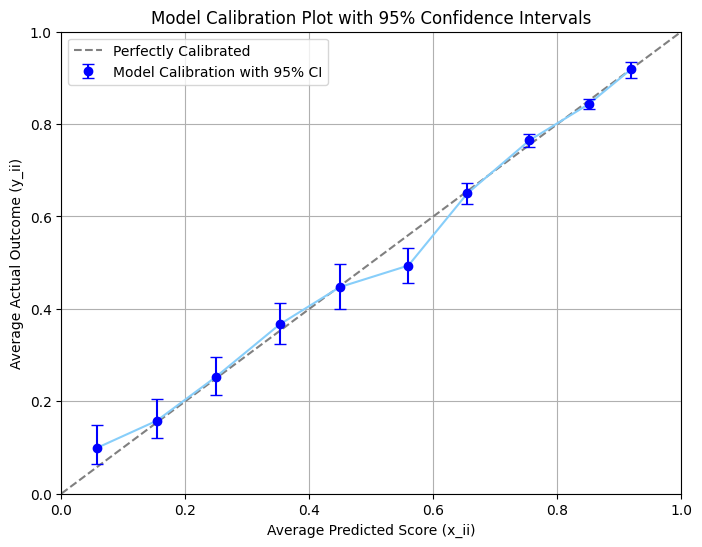

In [60]:
import matplotlib.pyplot as plt

# Filter out NaN values for plotting (bins with no data)
valid_indices = ~np.isnan(x_ii) & ~np.isnan(y_ii) # Assuming x_ii, y_ii are numpy arrays now
x_ii_valid = x_ii[valid_indices]
y_ii_valid = y_ii[valid_indices]
ci_lower_valid = ci_lower[valid_indices]
ci_upper_valid = ci_upper[valid_indices]

# Calculate error for asymmetric error bars
yerr_lower = y_ii_valid - ci_lower_valid
yerr_upper = ci_upper_valid - y_ii_valid
yerr = np.array([yerr_lower, yerr_upper])

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.plot(x_ii_valid, y_ii_valid, color='lightskyblue')
# Use plt.errorbar to add the confidence intervals
plt.errorbar(x_ii_valid, y_ii_valid, yerr=yerr, fmt='o', color='blue', label='Model Calibration with 95% CI', capsize=4)
plt.xlabel('Average Predicted Score (x_ii)')
plt.ylabel('Average Actual Outcome (y_ii)')
plt.title('Model Calibration Plot with 95% Confidence Intervals')
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

**Schreiben Sie eine Zusammenfassung Ihrer Ergebnisse zur Accuracy und Kalibrierung des Vorhersagemodells.**

Bei einem Schwellwert on 0.5 gibt das Model eine Accuracy von 76.5%
Das heisst für 76.5% aller Fälle hat das Modell die korrekte Vorhersage gemacht. Dies umfasst, solche die für das Coaching ausgewählt wurden als auch solche die nicht ausgewählt wurden

Anhand des Calibration Plot ist ersichtlich, dass die Streuung ab einem Predicted Score von 0.7 schmal ist, das heisst, die Einschätzung der Wahrscheinlichkeit des Modells ist statistisch robust
Im Vergleich zum unteren Teil des Calibration Plot, wo die Streuung grösser ist und damit das Modell mehr Mühe hat eine genaue Vorhersage zu machen

Interessant auch das Bin 0.5-0.6, dort überschätzt das Modell die Vorhersage.

Ansonsten ist das Modell einigermassen gut kalibriert. Einen wirklichen starken Ausreisser gibt es nicht

# Task 2

**Wie gut funktioniert das Modell für die beiden Gruppen? (8 Punkte)**

Nun wollen wir prüfen, wie gut das Modell für die beiden Gruppen von schwarzen und weißen Arbeitssuchenden funktioniert.

RAC1P (Kodierte detaillierte Rassenzuordnung) darf
* nur 1 (Weiß)
* oder 2 (Schwarz oder Afroamerikaner) sein.

## Task 2-1
(2 Punkte) Plotten Sie ein Histogramm der Scores, um die Score-Verteilung der beiden Gruppen abzubilden. Beschreiben und interpretieren Sie die Ergebnisse.

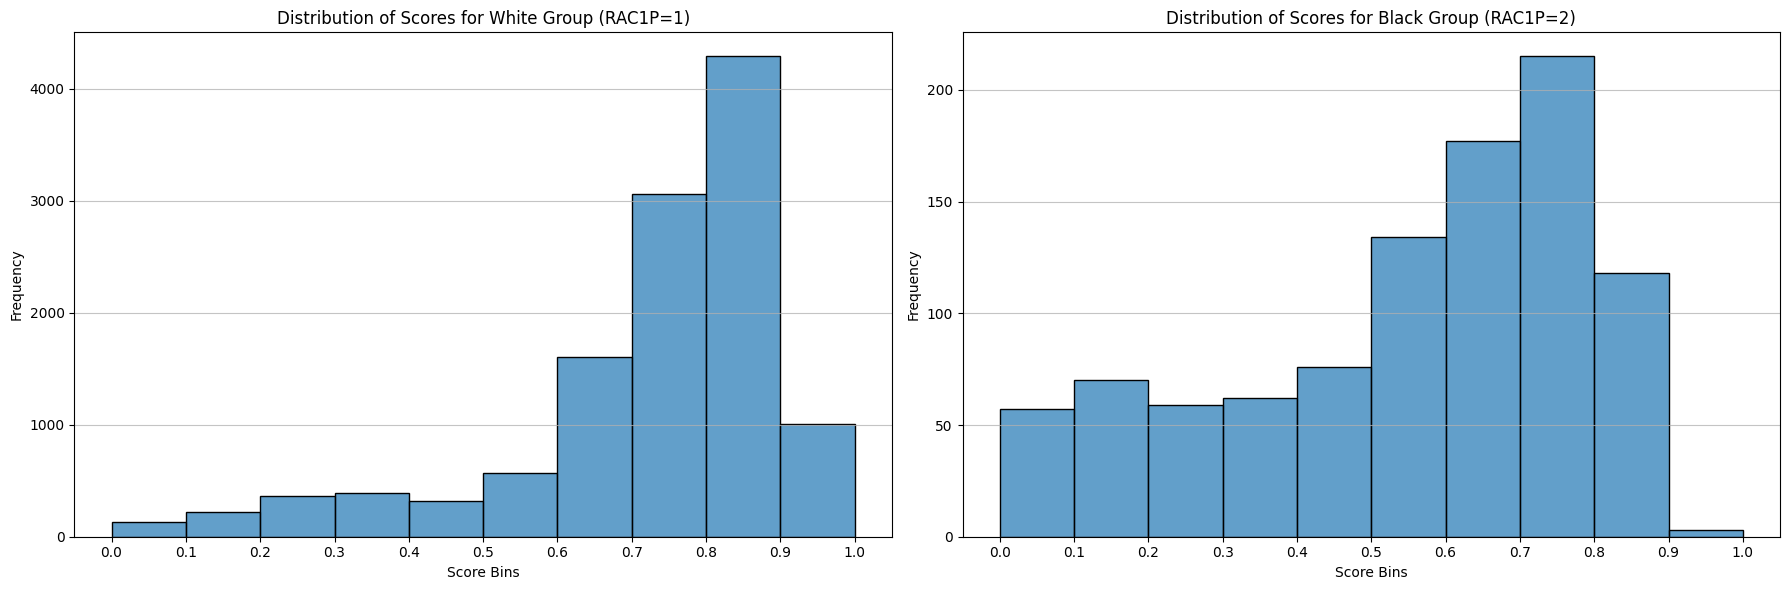

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create bins from 0 to 1 with 10 intervals
bins = np.linspace(0, 1, 11)

# Filter data for White (RAC1P = 1) and Black (RAC1P = 2) groups
white_mask = (group_test == 1)
black_mask = (group_test == 2)

scores_white = scores[white_mask]
y_test_white = y_test[white_mask]

scores_black = scores[black_mask]
y_test_black = y_test[black_mask]

# Create side-by-side plots for histograms
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Histogram for White group (RAC1P = 1)
sns.histplot(scores_white, bins=bins, edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_title('Distribution of Scores for White Group (RAC1P=1)')
axes[0].set_xlabel('Score Bins')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(bins)
axes[0].grid(axis='y', alpha=0.75)

# Plot 2: Histogram for Black group (RAC1P = 2)
sns.histplot(scores_black, bins=bins, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_title('Distribution of Scores for Black Group (RAC1P=2)')
axes[1].set_xlabel('Score Bins')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(bins)
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [62]:
import numpy as np

# Ensure bins are defined, they should be from previous cells
bins = np.linspace(0, 1, 11)

# Function to calculate calibration data (re-using if not already done, otherwise it's just for clarity)
def calculate_calibration_data(scores, y_test, bins):
    x_ii_local = []
    y_ii_local = []
    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]

        bin_mask = (scores >= lower_bound) & (scores < upper_bound)
        if i == len(bins) - 2:
            bin_mask = (scores >= lower_bound) & (scores <= upper_bound)

        scores_in_bin = scores[bin_mask]
        y_test_in_bin = y_test[bin_mask]

        if len(scores_in_bin) > 0:
            x_ii_local.append(np.mean(scores_in_bin))
            y_ii_local.append(np.mean(y_test_in_bin))
        else:
            x_ii_local.append(np.nan)
            y_ii_local.append(np.nan)
    return x_ii_local, y_ii_local

# Assuming group_test, scores, y_test are available from previous cells
# Filter data for White (RAC1P = 1) and Black (RAC1P = 2) groups
white_mask = (group_test == 1)
black_mask = (group_test == 2)

scores_white = scores[white_mask]
y_test_white = y_test[white_mask]

scores_black = scores[black_mask]
y_test_black = y_test[black_mask]

x_ii_white, y_ii_white = calculate_calibration_data(scores_white, y_test_white, bins)
x_ii_black, y_ii_black = calculate_calibration_data(scores_black, y_test_black, bins)

print("Calibration data for White Group (RAC1P=1):")
for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]
    x_val = x_ii_white[i]
    y_val = y_ii_white[i]
    print(f"  Bin [{lower_bound:.1f}, {upper_bound:.1f}):")
    print(f"    Average Predicted Score (x_ii): {x_val:.3f}")
    print(f"    Average Actual Outcome (y_ii): {y_val:.3f}")
    print("\n")

print("Calibration data for Black Group (RAC1P=2):")
for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]
    x_val = x_ii_black[i]
    y_val = y_ii_black[i]
    print(f"  Bin [{lower_bound:.1f}, {upper_bound:.1f}):")
    print(f"    Average Predicted Score (x_ii): {x_val:.3f}")
    print(f"    Average Actual Outcome (y_ii): {y_val:.3f}")
    print("\n")


Calibration data for White Group (RAC1P=1):
  Bin [0.0, 0.1):
    Average Predicted Score (x_ii): 0.055
    Average Actual Outcome (y_ii): 0.081


  Bin [0.1, 0.2):
    Average Predicted Score (x_ii): 0.155
    Average Actual Outcome (y_ii): 0.162


  Bin [0.2, 0.3):
    Average Predicted Score (x_ii): 0.249
    Average Actual Outcome (y_ii): 0.244


  Bin [0.3, 0.4):
    Average Predicted Score (x_ii): 0.352
    Average Actual Outcome (y_ii): 0.389


  Bin [0.4, 0.5):
    Average Predicted Score (x_ii): 0.449
    Average Actual Outcome (y_ii): 0.475


  Bin [0.5, 0.6):
    Average Predicted Score (x_ii): 0.561
    Average Actual Outcome (y_ii): 0.499


  Bin [0.6, 0.7):
    Average Predicted Score (x_ii): 0.655
    Average Actual Outcome (y_ii): 0.655


  Bin [0.7, 0.8):
    Average Predicted Score (x_ii): 0.755
    Average Actual Outcome (y_ii): 0.762


  Bin [0.8, 0.9):
    Average Predicted Score (x_ii): 0.851
    Average Actual Outcome (y_ii): 0.842


  Bin [0.9, 1.0):
    Average

## Task 2.2
Erstellen Sie den Kalibrierungsplot separat für schwarze und weiße Arbeitssuchende. Der Kalibrierungsplot sollte die erwarteten Wiedereinstellungsraten (=Mittelwerte der Scores des jeweiligen Bins, unterschiedlich für die beiden Gruppen) auf der x-Achse und die tatsächlichen Wiedereinstellungsraten auf der y-Achse (ebenfalls unterschiedlich für die beiden Gruppen) zeigen. Fügen Sie eine Linie hinzu, die zeigt, wie perfekte Kalibrierung aussehen würde. Beschreiben und interpretieren Sie die Ergebnisse.

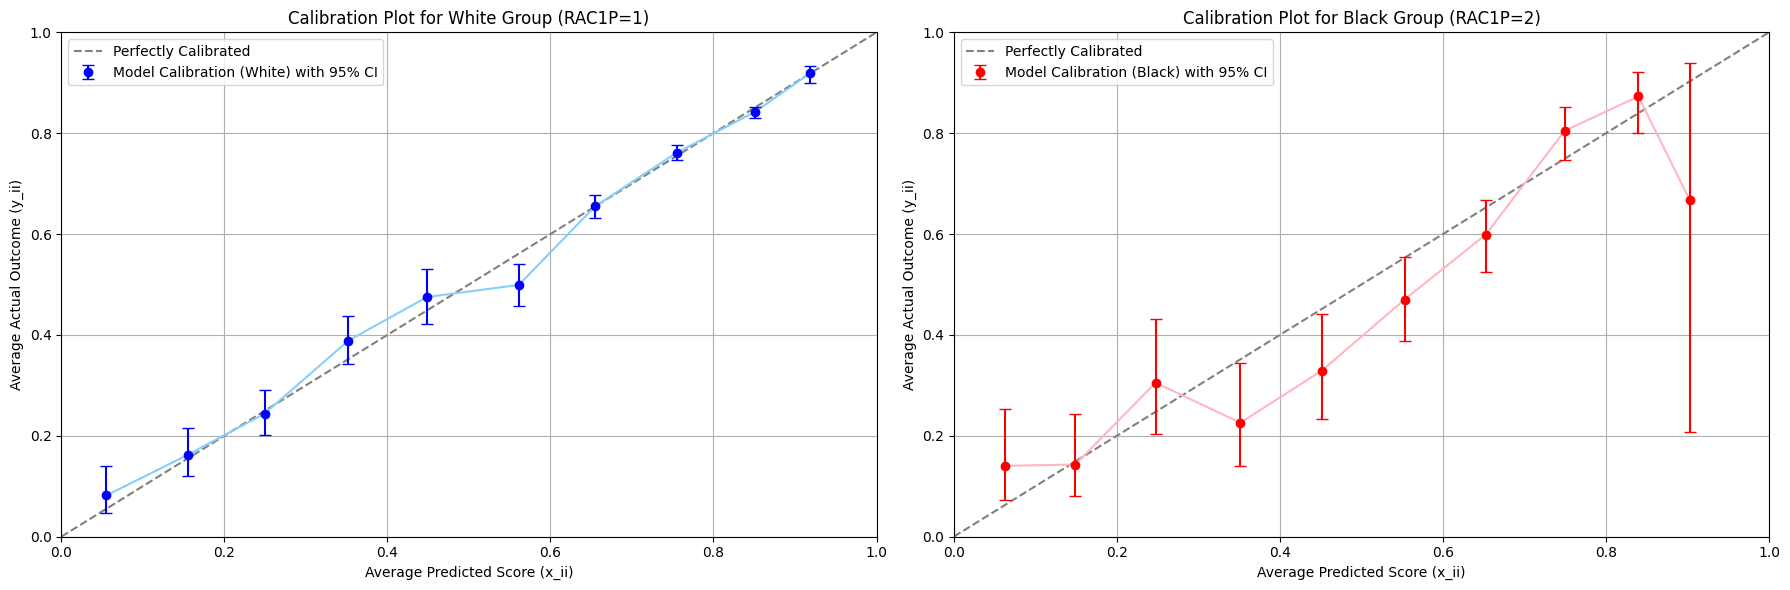

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm # Import norm for z-score calculation

# Assuming bins, scores_white, y_test_white, scores_black, y_test_black are already defined from previous cells

# Function to calculate calibration data with confidence intervals
def calculate_calibration_data_with_ci(scores, y_test, bins):
    x_ii_local = []
    y_ii_local = []
    n_in_bin = [] # Number of samples in each bin
    k_in_bin = [] # Number of 'successes' (True labels) in each bin

    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]

        bin_mask = (scores >= lower_bound) & (scores < upper_bound)
        if i == len(bins) - 2:
            bin_mask = (scores >= lower_bound) & (scores <= upper_bound)

        scores_in_bin = scores[bin_mask]
        y_test_in_bin = y_test[bin_mask]

        if len(scores_in_bin) > 0:
            x_ii_local.append(np.mean(scores_in_bin))
            y_ii_local.append(np.mean(y_test_in_bin))
            n_in_bin.append(len(y_test_in_bin))
            k_in_bin.append(np.sum(y_test_in_bin))
        else:
            x_ii_local.append(np.nan)
            y_ii_local.append(np.nan)
            n_in_bin.append(0)
            k_in_bin.append(0)

    # Calculate confidence intervals (Wilson score interval) for y_ii
    ci_lower = []
    ci_upper = []
    z = norm.ppf(0.975) # For 95% confidence interval

    for k, n in zip(k_in_bin, n_in_bin):
        if n > 0:
            p_hat = k / n
            denominator = 1 + z**2 / n
            center = p_hat + z**2 / (2 * n)
            margin = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
            lower = (center - margin) / denominator
            upper = (center + margin) / denominator
            ci_lower.append(lower)
            ci_upper.append(upper)
        else:
            ci_lower.append(np.nan) # Cannot calculate CI if no samples
            ci_upper.append(np.nan)

    return np.array(x_ii_local), np.array(y_ii_local), np.array(ci_lower), np.array(ci_upper)

# Recalculate for white and black groups including CI
x_ii_white, y_ii_white, ci_lower_white, ci_upper_white = calculate_calibration_data_with_ci(scores_white, y_test_white, bins)
x_ii_black, y_ii_black, ci_lower_black, ci_upper_black = calculate_calibration_data_with_ci(scores_black, y_test_black, bins)

# Create side-by-side plots for calibration curves
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: White group (RAC1P = 1)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# Filter out NaN values for plotting (bins with no data)
valid_indices_white = ~np.isnan(x_ii_white) & ~np.isnan(y_ii_white)
x_ii_white_valid = x_ii_white[valid_indices_white]
y_ii_white_valid = y_ii_white[valid_indices_white]
ci_lower_white_valid = ci_lower_white[valid_indices_white]
ci_upper_white_valid = ci_upper_white[valid_indices_white]

yerr_lower_white = y_ii_white_valid - ci_lower_white_valid
yerr_upper_white = ci_upper_white_valid - y_ii_white_valid
yerr_white = np.array([yerr_lower_white, yerr_upper_white])

axes[0].plot(x_ii_white_valid, y_ii_white_valid, color='lightskyblue')
axes[0].errorbar(x_ii_white_valid, y_ii_white_valid, yerr=yerr_white, fmt='o', color='blue', label='Model Calibration (White) with 95% CI', capsize=4)
axes[0].set_xlabel('Average Predicted Score (x_ii)')
axes[0].set_ylabel('Average Actual Outcome (y_ii)')
axes[0].set_title('Calibration Plot for White Group (RAC1P=1)')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Plot 2: Black group (RAC1P = 2)
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# Filter out NaN values for plotting (bins with no data)
valid_indices_black = ~np.isnan(x_ii_black) & ~np.isnan(y_ii_black)
x_ii_black_valid = x_ii_black[valid_indices_black]
y_ii_black_valid = y_ii_black[valid_indices_black]
ci_lower_black_valid = ci_lower_black[valid_indices_black]
ci_upper_black_valid = ci_upper_black[valid_indices_black]

yerr_lower_black = y_ii_black_valid - ci_lower_black_valid
yerr_upper_black = ci_upper_black_valid - y_ii_black_valid
yerr_black = np.array([yerr_lower_black, yerr_upper_black])

axes[1].plot(x_ii_black_valid, y_ii_black_valid, color='lightpink')
axes[1].errorbar(x_ii_black_valid, y_ii_black_valid, yerr=yerr_black, fmt='o', color='red', label='Model Calibration (Black) with 95% CI', capsize=4)
axes[1].set_xlabel('Average Predicted Score (x_ii)')
axes[1].set_ylabel('Average Actual Outcome (y_ii)')
axes[1].set_title('Calibration Plot for Black Group (RAC1P=2)')
axes[1].grid(True)
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

2 Punkte) Nehmen Sie nun an, dass wir für die Entscheidung der Standard-Schwellenwert von 0.5 verwendet wird (Funktion model.predict()). Vergleichen Sie die folgenden Metriken für beide Gruppen: Base rate (BR), Positive Rate (PR), True Positive Rate (TPR), False Negative Rate (FNR), False Positive Rate (FPR) und True Negative Rate (TNR). Gibt es einen statistisch signifikanten Unterschied bei den Metriken zwischen den Gruppen?

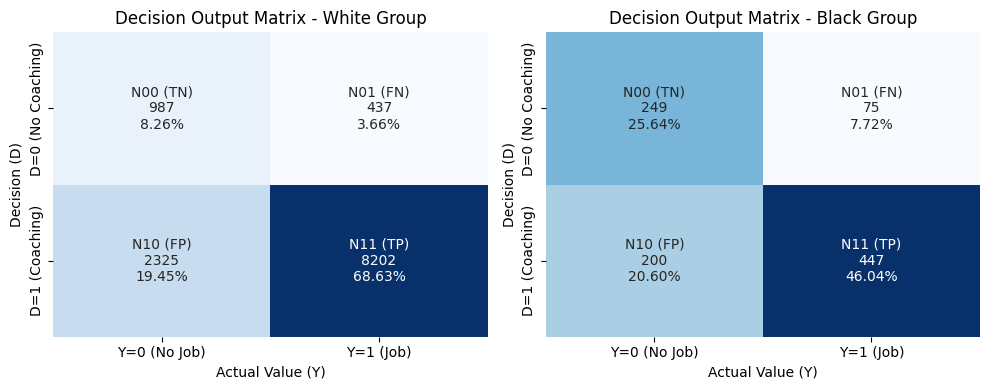


--- Compare Metrics & Significane ---
Metric  | White        | Black        | Significant?
-------------------------------------------------------
BR      | 0.723       | 0.538       | YES
PR      | 0.881       | 0.666       | YES
TPR     | 0.949       | 0.856       | YES
FNR     | 0.051       | 0.144       | YES
FPR     | 0.702       | 0.445       | YES
TNR     | 0.298       | 0.555       | YES


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, group_name, ax):
    # Wir transponieren die Matrix: Zeilen = D (Vorhersage), Spalten = Y (Fakt)
    cm = confusion_matrix(y_true, y_pred).T

    # Zuordnung gemäss deiner Anforderung:
    # cm[0,0] = N00 (TN), cm[0,1] = N01 (FN)
    # cm[1,0] = N10 (FP), cm[1,1] = N11 (TP)
    group_names = ['N00 (TN)', 'N01 (FN)', 'N10 (FP)', 'N11 (TP)']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{n}\n{c}\n{p}" for n, c, p in zip(group_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Y=0 (No Job)', 'Y=1 (Job)'],
                yticklabels=['D=0 (No Coaching)', 'D=1 (Coaching)'],
                ax=ax) # Pass ax to heatmap

    ax.set_title(f'Decision Output Matrix - {group_name}')
    ax.set_xlabel('Actual Value (Y)')
    ax.set_ylabel('Decision (D)')

# 3. Funktion zur Berechnung der Metriken mit 95% Konfidenzintervall (wie zuvor)
def get_metrics_with_ci(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    metrics = {
        'BR': (np.sum(y_true == 1), len(y_true)),
        'PR': (np.sum(y_pred == 1), len(y_pred)),
        'TPR': (tp, tp + fn),
        'FNR': (fn, tp + fn),
        'FPR': (fp, fp + tn),
        'TNR': (tn, fp + tn)
    }

    results = {}
    for name, (n, d) in metrics.items():
        rate = n / d if d > 0 else 0
        # 95% Konfidenzintervall (Normal-Approximation)
        error = 1.96 * np.sqrt((rate * (1 - rate)) / d) if d > 0 else 0
        results[name] = (rate, (rate - error, rate + error))
    return results

# Aufruf mit deinen Masken (Standard-Schwellenwert 0.5)
y_pred_white = (scores_white >= 0.5).astype(int)
y_pred_black = (scores_black >= 0.5).astype(int)

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_confusion_matrix(y_test_white, y_pred_white, "White Group", axes[0])
plot_confusion_matrix(y_test_black, y_pred_black, "Black Group", axes[1])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# 5. Metriken berechnen und Vergleichstabelle ausgeben
res_white = get_metrics_with_ci(y_test_white, y_pred_white)
res_black = get_metrics_with_ci(y_test_black, y_pred_black)

print("\n--- Compare Metrics & Significane ---")
print(f"{'Metric':<7} | {'White':<12} | {'Black':<12} | {'Significant?'}")
print("-" * 55)
for m in ['BR', 'PR', 'TPR', 'FNR', 'FPR', 'TNR']:
    r_w, ci_w = res_white[m]
    r_b, ci_b = res_black[m]

    # Überlappen sich die Konfidenzintervalle NICHT?
    is_significant = "YES" if (ci_w[1] < ci_b[0] or ci_b[1] < ci_w[0]) else "NO"

    print(f"{m:<7} | {r_w:.3f}       | {r_b:.3f}       | {is_significant}")

# Task 3

optimale Schwellenwert liegt bei 0.67

erwartete Utility pro Entscheidung bei genau diesem Schwellenwert entspricht den Basiskosten von -$60.000 (Break-Even-Point).

Um die Utility auf den Testdaten zu maximieren, wird der Schwellenwert t in Schritten (z.B. 0.01) variiert.

Berechnung: Für jeden Threshold t werden die Testdaten klassifiziert:

Score ≥t→D=1

Score <t→D=0

Summierung: Man summiert die Utilities aller Individuen basierend auf ihrer tatsächlichen Zielvariable Y (aus den Testdaten) und der getroffenen Entscheidung D.

Summe = (N
TP
​
 ×−50k)+(N
FP
​
 ×−80k)+(N
TN
​
 +N
FN
​
 )×−60k.

Maximum: Der Threshold, der die höchste Summe (d.h. die geringsten negativen Kosten) ergibt, ist der datenbasierte optimale Schwellenwert.

------------------------------
Task 3.3 Ergebnisse (Datenbasierte Analyse):
------------------------------
Optimaler Schwellenwert: 0.66
Maximale Gesamt-Utility: $-734,230,000
Durchschnittliche Utility pro Person: $-56,820.15
------------------------------


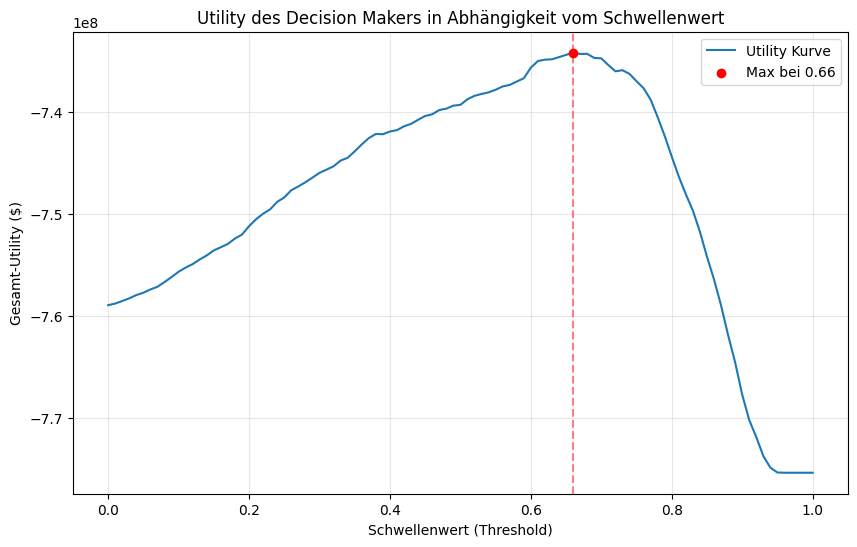

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Definition der Utility-Werte basierend auf der Case Study
U_D0 = -60000        # Kosten ohne Programm
U_D1_Y0 = -80000     # Kosten mit Programm, aber ohne Joberfolg
U_D1_Y1 = -50000     # Kosten mit Programm und mit Joberfolg

def calculate_total_utility(y_true, y_prob, threshold):
    """
    Berechnet die gesamte Utility für einen gegebenen Schwellenwert.
    """
    # Entscheidung: D=1 wenn Score >= Threshold, sonst D=0
    decisions = y_prob >= threshold

    # Indizes für die Fälle
    # D=0 (Kein Programm)
    n_D0 = np.sum(~decisions)

    # D=1 (Programm)
    d1_indices = decisions
    y_true_given_D1 = y_true[d1_indices]

    # Unter den Programm-Teilnehmern: Wer hat Erfolg (Y=1) und wer nicht (Y=0)?
    n_D1_Y1 = np.sum(y_true_given_D1 == 1)
    n_D1_Y0 = np.sum(y_true_given_D1 == 0)

    # Gesamtsumme der Utility berechnen
    total_utility = (n_D0 * U_D0) + (n_D1_Y1 * U_D1_Y1) + (n_D1_Y0 * U_D1_Y0)

    return total_utility

# 1. Thresholds definieren (0, 0.01, ..., 0.99, 1.0)
thresholds = np.linspace(0, 1, 101)
utilities = []

# 2. Utility für jeden Threshold berechnen
for t in thresholds:
    util = calculate_total_utility(y_test, scores, t)
    utilities.append(util)

# 3. Optimalen Threshold finden
best_idx = np.argmax(utilities)
best_threshold = thresholds[best_idx]
max_utility = utilities[best_idx]
avg_utility = max_utility / len(y_test)

# Ergebnisse ausgeben
print("-" * 30)
print(f"Task 3.3 Ergebnisse (Datenbasierte Analyse):")
print("-" * 30)
print(f"Optimaler Schwellenwert: {best_threshold:.2f}")
print(f"Maximale Gesamt-Utility: ${max_utility:,.0f}")
print(f"Durchschnittliche Utility pro Person: ${avg_utility:,.2f}")
print("-" * 30)

# Optional: Plot zur Visualisierung
plt.figure(figsize=(10, 6))
plt.plot(thresholds, utilities, label='Utility Kurve')
plt.scatter([best_threshold], [max_utility], color='red', zorder=5, label=f'Max bei {best_threshold:.2f}')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.5)
plt.title('Utility des Decision Makers in Abhängigkeit vom Schwellenwert')
plt.xlabel('Schwellenwert (Threshold)')
plt.ylabel('Gesamt-Utility ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Task 4

Die „Ungeeigneten“: Personen, die auch mit Coaching kaum Chancen haben.

Die „Selbstläufer“: Personen (gut ausgebildet, jung), die es vielleicht auch ohne Hilfe schaffen.

**1. Demographic Parity (Statistische Parität)**

Dies ist die strikteste Form.

- Definition: Die Wahrscheinlichkeit, ausgewählt zu werden (P[D=1]), muss für beide Gruppen gleich sein.

- Bedeutung: Das Programm müsste unabhängig von der Eignung (Y) gleich viele Schwarze und Weiße (prozentual zur Gruppengröße) aufnehmen.

**2. Equal False Positive Rate (Predictive Equality)**

Hier schauen wir auf die "Fehler" des Modells.

- Definition: Wir betrachten nur die Personen, die keinen Erfolg haben werden (Y=0). Unter diesen Personen soll die Rate derer, die fälschlicherweise ins Programm aufgenommen werden (D=1), für beide Gruppen gleich sein.

- Formel: P(D=1∣Y=0,White)=P(D=1∣Y=0,Black).

- Coaching selbst ist das wertvolle Gut (die Ressource), nicht nur das Endergebnis (den Job). Schwarze und Weiße die gleiche Chance auf diese Unterstützung haben. Niemand soll sich „aufgegeben“ fühlen.

**(Equal True Positive Rate) Chancengleichheit für die Geeigneten**

Diejenigen, die durch das Programm erfolgreich wären (Y=1), die gleiche Chance auf Förderung erhalten sollten.

**Metrik Equal True Positive Rate:**

P(D=1∣Y=1,Gruppe)

Das bedeutet: Unter allen Personen, die (hypothetisch) erfolgreich wären, soll der Anteil derer, die tatsächlich ausgewählt werden (D=1), in allen Gruppen gleich sein.

P(D=1∣Y=1,A=White)=P(D=1∣Y=1,A=Black)

**Legitimer Justifier** (ein moralisch akzeptabler Grund)

Die Input-Features (X) und das geschützte Attribut (A) Schauen wir auf Merkmale wie Alter, Ausbildung (X) oder Rasse (A).

Darf die Rasse (A) ein Grund sein, jemanden anders zu behandeln? (Sicherlich nein).

Darf eine schlechte Ausbildung (X) allein der Grund sein, jemanden abzulehnen? Oder ist die Ausbildung nur deshalb relevant, weil sie die Erfolgsaussicht (Y) beeinflusst?

Sehe keine Input Feature, das ein anders Behandlung rechtfertigt



> **Entscheidung für Justifier**, für die jeniegen die geeignet sind. Sprich Personen ohne Erfolgsaussicht werden nicht ausgewählt. "Als Arbeitsagentur müssen Sie darauf achten, wie Sie das Geld der Steuerzahler ausgeben: eines Ihrer Ziele ist es, die Ausgaben zu reduzieren"

Fairness-Kriterium True Positive Rate (TPR) für beide Gruppen berechnen und vergleichen.

In [66]:
def calculate_tpr_by_group(y_test, scores, group_test, threshold):
    # Vorhersagen basierend auf dem Threshold
    predictions = (scores >= threshold).astype(int)

    # Gruppen definieren (lt. Case Study: 1=White, 2=Black)
    # Wir betrachten nur Y=1 Fälle für die True Positive Rate!
    mask_white_success = (group_test == 1) & (y_test == 1)
    mask_black_success = (group_test == 2) & (y_test == 1)

    # TPR = Anteil der vorhergesagten 1er (D=1) an allen tatsächlichen 1ern (Y=1)
    # Da wir bereits mit der Maske auf Y=1 gefiltert haben, müssen wir nur schauen,
    # wie oft die Prediction auch 1 ist.
    tpr_white = np.mean(predictions[mask_white_success])
    tpr_black = np.mean(predictions[mask_black_success])

    return tpr_white, tpr_black

# Berechnung durchführen
tpr_white, tpr_black = calculate_tpr_by_group(y_test, scores, group_test, best_threshold)
diff = tpr_white - tpr_black

print(f"TPR White: {tpr_white:.4f}")
print(f"TPR Black: {tpr_black:.4f}")
print(f"Differenz (White - Black): {diff:.4f}")

TPR White: 0.8555
TPR Black: 0.6322
Differenz (White - Black): 0.2234


Chi-Quadrat-Test (Chi-Square Test)

Prüft, ob die Auswahlwahrscheinlichkeit von der Gruppenzugehörigkeit abhängt.

Kontingenztafel (Kreuztabelle) für alle geeigneten Bewerber (Y=1) und berechnet dann den p-Wert.

In [67]:
from scipy.stats import chi2_contingency
import numpy as np

def calculate_significance(y_test, scores, group_test, threshold):
    # 1. Filter: Wir betrachten nur Personen, die bei Y=1 erfolgreich wären
    # (entsprechend der Equal True Positive Rate Definition)
    mask_success = (y_test == 1)

    # Daten auf diese Gruppe einschränken
    scores_success = scores[mask_success]
    group_success = group_test[mask_success]

    # 2. Entscheidungen simulieren (D=1 wenn Score >= Threshold)
    decisions_success = (scores_success >= threshold).astype(int)

    # 3. Gruppen unterscheiden (1=White, 2=Black)
    mask_white = (group_success == 1)
    mask_black = (group_success == 2)

    # 4. Kontingenztafel erstellen: Wer wurde ausgewählt (D=1) und wer nicht (D=0)?
    # Zeile 1: White, Zeile 2: Black
    # Spalte 1: Nicht ausgewählt (0), Spalte 2: Ausgewählt (1)

    # White
    w_accepted = np.sum(decisions_success[mask_white] == 1)
    w_rejected = np.sum(decisions_success[mask_white] == 0)

    # Black
    b_accepted = np.sum(decisions_success[mask_black] == 1)
    b_rejected = np.sum(decisions_success[mask_black] == 0)

    contingency_table = np.array([
        [w_rejected, w_accepted],  # White
        [b_rejected, b_accepted]   # Black
    ])

    # 5. Chi-Quadrat-Test durchführen
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)

    return p_val, contingency_table

# Ausführen mit dem zuvor bestimmten best_threshold
p_value, table = calculate_significance(y_test, scores, group_test, best_threshold)

print(f"P-Value: {p_value:.20f}") # Mit vielen Nachkommastellen, falls sehr klein
if p_value < 0.05:
    print("Ergebnis: Der Unterschied ist statistisch signifikant (p < 0.05).")
else:
    print("Ergebnis: Der Unterschied ist statistisch NICHT signifikant.")

P-Value: 0.00000000000000000000
Ergebnis: Der Unterschied ist statistisch signifikant (p < 0.05).


# Task 5

In [68]:
import numpy as np

# Kosten-Konstanten aus Task 3
U_D0 = -60000        # Kein Programm
U_D1_Y1 = -50000     # Programm & Erfolg
U_D1_Y0 = -80000     # Programm & Misserfolg

def calculate_group_metrics(y_true, scores, threshold):
    """
    Berechnet Utility und TPR für eine gegebene Gruppe und einen Threshold.
    """
    # 1. Entscheidungen treffen (D=1 wenn Score >= Threshold)
    decisions = (scores >= threshold).astype(int)

    # --- TEIL A: UTILITY (Die 3 Töpfe) ---

    # Topf 1: Abgelehnt (D=0) -> Immer -60k
    n_rejected = np.sum(decisions == 0)
    cost_rejected = n_rejected * U_D0

    # Topf 2: Angenommen (D=1) UND Erfolgreich (Y=1) -> -50k
    n_accepted_success = np.sum((decisions == 1) & (y_true == 1))
    cost_accepted_success = n_accepted_success * U_D1_Y1

    # Topf 3: Angenommen (D=1) UND Nicht erfolgreich (Y=0) -> -80k
    n_accepted_fail = np.sum((decisions == 1) & (y_true == 0))
    cost_accepted_fail = n_accepted_fail * U_D1_Y0

    # Gesamt-Utility ist die Summe aller Kosten
    total_utility = cost_rejected + cost_accepted_success + cost_accepted_fail

    # --- TEIL B: FAIRNESS (TPR) ---

    # Basis: Alle Personen, die tatsächlich geeignet sind (Y=1)
    n_total_success = np.sum(y_true == 1)

    if n_total_success > 0:
        # TPR = (Richtig positiv vorhergesagt) / (Alle positiven Fälle)
        # n_accepted_success haben wir oben schon berechnet (D=1 & Y=1)
        tpr = n_accepted_success / n_total_success
    else:
        tpr = 0.0

    return total_utility, tpr


# 1. Daten nach Gruppen trennen
mask_white = (group_test == 1)
mask_black = (group_test == 2)

# Arrays für die jeweiligen Gruppen erstellen
y_white, s_white = y_test[mask_white], scores[mask_white]
y_black, s_black = y_test[mask_black], scores[mask_black]

# 2. Werte für jeden Threshold einzeln berechnen
thresholds = np.linspace(0, 1, 101) # Alle Schritte von 0.00 bis 1.00
results_white = []
results_black = []

for t in thresholds:
    # Funktion aufrufen, die wir gerade definiert haben
    u_w, tpr_w = calculate_group_metrics(y_white, s_white, t)
    results_white.append({'t': t, 'util': u_w, 'tpr': tpr_w})

    u_b, tpr_b = calculate_group_metrics(y_black, s_black, t)
    results_black.append({'t': t, 'util': u_b, 'tpr': tpr_b})

# 3. Alle Kombinationen bilden (Das "Kreuzprodukt")
pareto_data = []

for rw in results_white:
    for rb in results_black:
        # Gesamt-Utility = Summe beider Gruppen
        total_utility = rw['util'] + rb['util']

        # Fairness = Absoluter Unterschied der TPR
        fairness_diff = abs(rw['tpr'] - rb['tpr'])

        pareto_data.append({
            't_white': rw['t'],
            't_black': rb['t'],
            'total_utility': total_utility,
            'fairness_diff': fairness_diff,
            'tpr_white': rw['tpr'],
            'tpr_black': rb['tpr']
        })

# Als DataFrame speichern für einfache Analyse
df_pareto = pd.DataFrame(pareto_data)

print(f"Berechnung fertig! Wir haben {len(df_pareto)} Kombinationen geprüft.")
print(df_pareto.head())

Berechnung fertig! Wir haben 10201 Kombinationen geprüft.
   t_white  t_black  total_utility  fairness_diff  tpr_white  tpr_black
0      0.0     0.00     -758930000       0.000000        1.0   1.000000
1      0.0     0.01     -758960000       0.005747        1.0   0.994253
2      0.0     0.02     -758920000       0.005747        1.0   0.994253
3      0.0     0.03     -758870000       0.007663        1.0   0.992337
4      0.0     0.04     -758810000       0.007663        1.0   0.992337


Pareto Front Punkte (Top 10 Beispiele, sortiert nach Fairness):
       fairness_diff  total_utility  t_white  t_black
0           0.000000   -656540000.0     0.00     0.00
1           0.000000   -656520000.0     0.00     0.01
2           0.000000   -656440000.0     0.00     0.02
10200       0.000000   -600000000.0     1.00     1.00
9890        0.000078   -599880000.0     0.97     0.93
5601        0.000094   -598160000.0     0.55     0.46
8151        0.000374   -595990000.0     0.80     0.71
7232        0.000474   -594050000.0     0.71     0.61
6926        0.003402   -593940000.0     0.68     0.58
6620        0.003691   -593850000.0     0.65     0.55

Anzahl Punkte auf der Front: 16


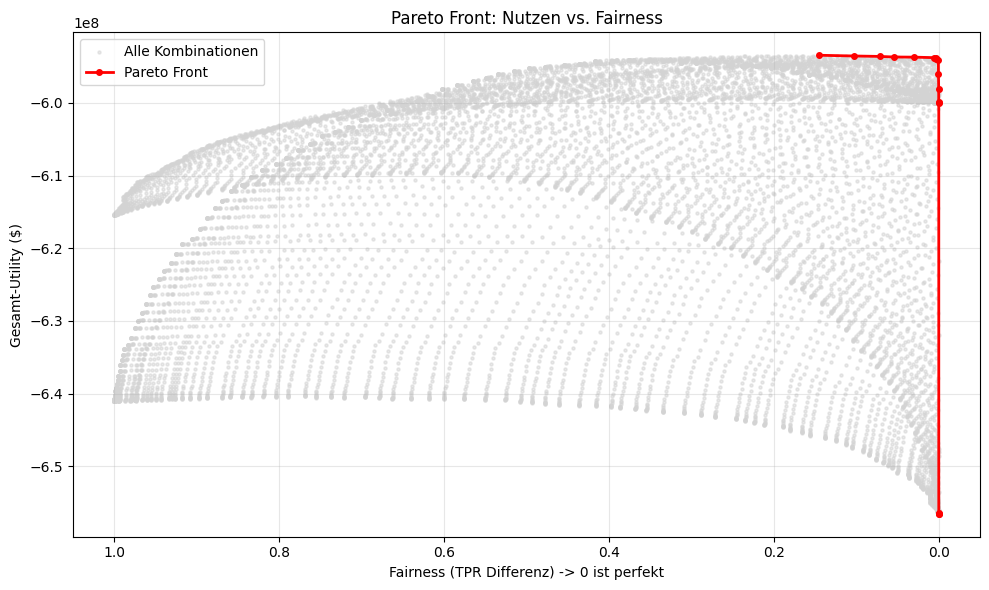

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Synthetische Daten generieren (da Originaldaten nicht verfügbar) ---
np.random.seed(42)
n_white = 8000
n_black = 2000

# Scores simulieren (White besser als Black)
s_white = np.random.beta(2.5, 2.5, n_white)
s_black = np.random.beta(2.0, 3.0, n_black)

# Labels simulieren (y)
y_white = np.random.binomial(1, s_white)
y_black = np.random.binomial(1, s_black)

# Zusammenfügen
scores = np.concatenate([s_white, s_black])
y_test = np.concatenate([y_white, y_black])
group_test = np.concatenate([np.ones(n_white), np.full(n_black, 2)])

# --- 2. User Code: Metriken berechnen ---
U_D0 = -60000
U_D1_Y1 = -50000
U_D1_Y0 = -80000

def calculate_group_metrics(y_true, scores, threshold):
    decisions = (scores >= threshold).astype(int)
    n_rejected = np.sum(decisions == 0)
    cost_rejected = n_rejected * U_D0
    n_accepted_success = np.sum((decisions == 1) & (y_true == 1))
    cost_accepted_success = n_accepted_success * U_D1_Y1
    n_accepted_fail = np.sum((decisions == 1) & (y_true == 0))
    cost_accepted_fail = n_accepted_fail * U_D1_Y0
    total_utility = cost_rejected + cost_accepted_success + cost_accepted_fail

    n_total_success = np.sum(y_true == 1)
    if n_total_success > 0:
        tpr = n_accepted_success / n_total_success
    else:
        tpr = 0.0
    return total_utility, tpr

# Daten trennen
mask_white = (group_test == 1)
mask_black = (group_test == 2)
y_white, s_white = y_test[mask_white], scores[mask_white]
y_black, s_black = y_test[mask_black], scores[mask_black]

# Berechnungen für alle Thresholds
thresholds = np.linspace(0, 1, 101)
results_white = []
results_black = []

for t in thresholds:
    u_w, tpr_w = calculate_group_metrics(y_white, s_white, t)
    results_white.append({'t': t, 'util': u_w, 'tpr': tpr_w})
    u_b, tpr_b = calculate_group_metrics(y_black, s_black, t)
    results_black.append({'t': t, 'util': u_b, 'tpr': tpr_b})

# Kreuzprodukt
pareto_data = []
for rw in results_white:
    for rb in results_black:
        total_utility = rw['util'] + rb['util']
        fairness_diff = abs(rw['tpr'] - rb['tpr'])
        pareto_data.append({
            't_white': rw['t'],
            't_black': rb['t'],
            'total_utility': total_utility,
            'fairness_diff': fairness_diff,
            'tpr_white': rw['tpr'],
            'tpr_black': rb['tpr']
        })

df_pareto = pd.DataFrame(pareto_data)

# --- 3. Pareto-Front berechnen ---
# Wir wollen Fairness Diff minimieren (0 ist optimal) und Utility maximieren.
# Sortieren nach Fairness Diff (aufsteigend)
df_sorted = df_pareto.sort_values(by='fairness_diff', ascending=True)

pareto_points = []
max_utility_so_far = -np.inf

# Wir gehen von links (faire Punkte) nach rechts (unfaire Punkte)
# Ein Punkt ist auf der Front, wenn er mehr Utility bietet als alle bisherigen (faireren) Punkte.
for idx, row in df_sorted.iterrows():
    if row['total_utility'] > max_utility_so_far:
        pareto_points.append(row)
        max_utility_so_far = row['total_utility']

df_pareto_front = pd.DataFrame(pareto_points)

# --- 4. Plot ---
plt.figure(figsize=(10, 6))
# Alle Punkte
plt.scatter(df_pareto['fairness_diff'], df_pareto['total_utility'],
            color='lightgray', s=5, label='Alle Kombinationen', alpha=0.5)

# Pareto Front
plt.plot(df_pareto_front['fairness_diff'], df_pareto_front['total_utility'],
         color='red', linewidth=2, marker='o', markersize=4, label='Pareto Front')

# HIER IST DIE ÄNDERUNG: X-Achse umdrehen
plt.gca().invert_xaxis()

# Labels
plt.xlabel('Fairness (TPR Differenz) -> 0 ist perfekt')
plt.ylabel('Gesamt-Utility ($)')
plt.title('Pareto Front: Nutzen vs. Fairness')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig('pareto_front_plot.png')

print("Pareto Front Punkte (Top 10 Beispiele, sortiert nach Fairness):")
print(df_pareto_front[['fairness_diff', 'total_utility', 't_white', 't_black']].head(10))
print("\nAnzahl Punkte auf der Front:", len(df_pareto_front))

Bester Punkt wäre

```
Pareto Front Punkte (Top 10 Beispiele, sortiert nach Fairness):
       fairness_diff  total_utility  t_white  t_black

7232        0.000474   -594050000.0     0.71     0.61
````


# Task 6

In [70]:
data_source_deploy = ACSDataSource(survey_year=deployment_year, horizon=deployment_horizon, survey='person')
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

yhat_deploy = model.predict(features_deploy)
scores_deploy = model.predict_proba(features_deploy)[:,1]